In [1]:
import tensorflow as tf
from keras import backend as K
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
K.tensorflow_backend.set_session(sess)

Using TensorFlow backend.


In [2]:
%%time
import os
import cv2
import collections

from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image
import time
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as maskUtils
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

from coco_preprocessing import *
from expl_train_utils import *

CPU times: user 9.39 s, sys: 325 ms, total: 9.71 s
Wall time: 10.3 s


In [3]:
from keras.backend.tensorflow_backend import set_session
from keras_contrib.applications.resnet import ResNet18
from keras.applications import vgg16
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Input
from keras.optimizers import Adam, SGD

### Load Dataset

In [4]:
dataDir=''
dataType='val2017'
annFile='annotations/instances_{}.json'.format(dataType)

In [5]:
# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.73s)
creating index...
index created!


In [6]:
num_cats = 10

In [7]:
# Get categories with largest number of images to use
numCatImgs = []
for i in range(90):
    numCatImgs.append((i, len(coco.getImgIds(catIds=i))))
numCatImgs.sort(key=lambda x: x[1])
usedCatImgs = numCatImgs[-num_cats:] # list of (catId, numImgs) tuples
minNumImgs = usedCatImgs[0][1] # number of images available for smallest used cat(egory)
used_ids = [tup[0] for tup in usedCatImgs] # list of catIds used

used_cats = coco.loadCats(coco.getCatIds(catIds=used_ids))
cat_names = [cat['name'] for cat in used_cats]
print('{} COCO categories used: \n{}\n'.format(len(used_cats), ' '.join(cat_names)))

10 COCO categories used: 
person car truck bench handbag bottle cup bowl chair dining table



In [8]:
print(used_ids)

[15, 8, 31, 51, 44, 47, 67, 3, 62, 1]


In [9]:
catId_to_catName = {d['id']: d['name'] for d in used_cats}

### Load All Images

In [10]:
imgIds = [img_info for used_id in used_ids for img_info in coco.getImgIds(catIds=used_id)]

In [11]:
%%time
# preprocess --> bboxImgs, object_labels, configs, shapelyPolygons
data = [preprocess(coco, img_info, used_ids) for img_info in coco.loadImgs(imgIds)[:100]]
data = np.array(data)
np.random.shuffle(data)

CPU times: user 2.02 s, sys: 73.8 ms, total: 2.09 s
Wall time: 1min


### Using Keras VGG16 Model

In [12]:
# input_tensor = Input(shape=(96, 96, 3))
# inet_model = vgg16.VGG16(input_tensor=input_tensor, weights=None, include_top=False)
inet_model = ResNet18((96, 96, 3), 10)
model = inet_model

reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...


In [13]:
num_samples = 100
batch_size = 10
num_classes = 10
num_batches = num_samples // batch_size
iteration = 0

base_model = inet_model
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(1024, activation='relu')(x)
# predictions = Dense(num_classes, activation='softmax')(x)
# model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy',
              metrics=['acc'])

In [14]:
x_train = data[:, 0] # Bbox images

# bbox_imgs = []
temp = []
for bbox_imgs in x_train:
    for img in bbox_imgs:
        if len(img.shape) != 3:
            img = np.stack((img,) * 3, -1)
#         bbox_imgs.append(img)
        alt_img = cv2.resize(img, dsize=(96, 96), interpolation=cv2.INTER_CUBIC)
        temp.append(alt_img)

x_train = np.array(temp)

In [15]:
print(x_train.shape)
print(np.array(bbox_imgs).shape)

(737, 96, 96, 3)
(21,)


In [16]:
y_train = data[:, 1]
y_train = np.array([label[0] for labels in y_train for label in labels])

temp = np.zeros((y_train.shape[0], num_cats))
for ft in used_ids:
    vec = np.zeros(num_cats)
    vec[used_ids.index(ft)] = 1
    temp[np.where(y_train == ft)] = vec

y_train = temp

In [17]:
configs = np.array([config for configs in data[:, 2] for config in configs])

In [18]:
shapely_polygons = np.array([polygon for polygons in data[:, 3] for polygon in polygons])

In [19]:
# Single Image Inference Time
times = []
for i in range(100):
    s = time.time()
    preds = model.predict(x_train[i][np.newaxis,])
    times.append(time.time() - s)
print("Single Image Inference Time: {} seconds".format(sum(times) / len(times)))

Single Image Inference Time: 0.05168129205703735 seconds


In [38]:
%%time
"""
# Model training benchmarks
num_epochs = 10
stats = {} # epoch num -> [loss, accuracy, time]

for i in range(1, num_epochs + 1):
    s = time.time()
    model.fit(x_train, y_train,
              epochs=1,
              batch_size=128,
              shuffle=False,
              validation_split=0.1,
              verbose=2)
    t = time.time() - s
    
    model.save_weights('saved_weights/{}.hdf5'.format(i))
    
    stats[i] = model.evaluate(x_train, y_train, batch_size=128, verbose=0) + [t]
"""

Train on 40344 samples, validate on 4483 samples
Epoch 1/1
 - 103s - loss: 1.9238 - acc: 0.5312 - val_loss: 2.2037 - val_acc: 0.5271
Train on 40344 samples, validate on 4483 samples
Epoch 1/1
 - 98s - loss: 1.3266 - acc: 0.6664 - val_loss: 1.4344 - val_acc: 0.6567
Train on 40344 samples, validate on 4483 samples
Epoch 1/1
 - 98s - loss: 0.9470 - acc: 0.7925 - val_loss: 1.1724 - val_acc: 0.7504
Train on 40344 samples, validate on 4483 samples
Epoch 1/1
 - 98s - loss: 0.7084 - acc: 0.8740 - val_loss: 1.3161 - val_acc: 0.7399
Train on 40344 samples, validate on 4483 samples
Epoch 1/1
 - 98s - loss: 0.5949 - acc: 0.9122 - val_loss: 1.1162 - val_acc: 0.8055
Train on 40344 samples, validate on 4483 samples
Epoch 1/1
 - 98s - loss: 0.5397 - acc: 0.9325 - val_loss: 1.0375 - val_acc: 0.8213
Train on 40344 samples, validate on 4483 samples
Epoch 1/1
 - 98s - loss: 0.5092 - acc: 0.9432 - val_loss: 0.8994 - val_acc: 0.8601
Train on 40344 samples, validate on 4483 samples
Epoch 1/1
 - 98s - loss: 0

In [20]:
model.load_weights('saved_weights/1.hdf5')

Epsilon-Greedy Sampling Time: 0.0001246929168701172 seconds
Perturbed Data Classification Time: 0.05592060089111328 seconds
data_labels Time: 0.07447671890258789 seconds
Average Epsilon-Greedy Image Creation Time: 0.0006182909011840821 seconds
Average Perturbed Data Point Creation Time: 8.471310138702393e-06 seconds
Average Epsilon-Greedy 10 Image Classification Time: 0.006090354919433594 seconds
Average Reward, Count, and Q-Value Eval Time: 0.00012302398681640625 seconds
Feature Selection Time: 3.0040740966796875e-05 seconds
Ridge Regression Time: 0.0028123855590820312 seconds
Prediction Time: 0.0005872249603271484 seconds
Epsilon-Greedy Sampling Time: 0.00010466575622558594 seconds
Perturbed Data Classification Time: 0.05376005172729492 seconds
data_labels Time: 0.07192540168762207 seconds
Average Epsilon-Greedy Image Creation Time: 0.0008118557929992676 seconds
Average Perturbed Data Point Creation Time: 7.063150405883789e-06 seconds
Average Epsilon-Greedy 10 Image Classification Ti

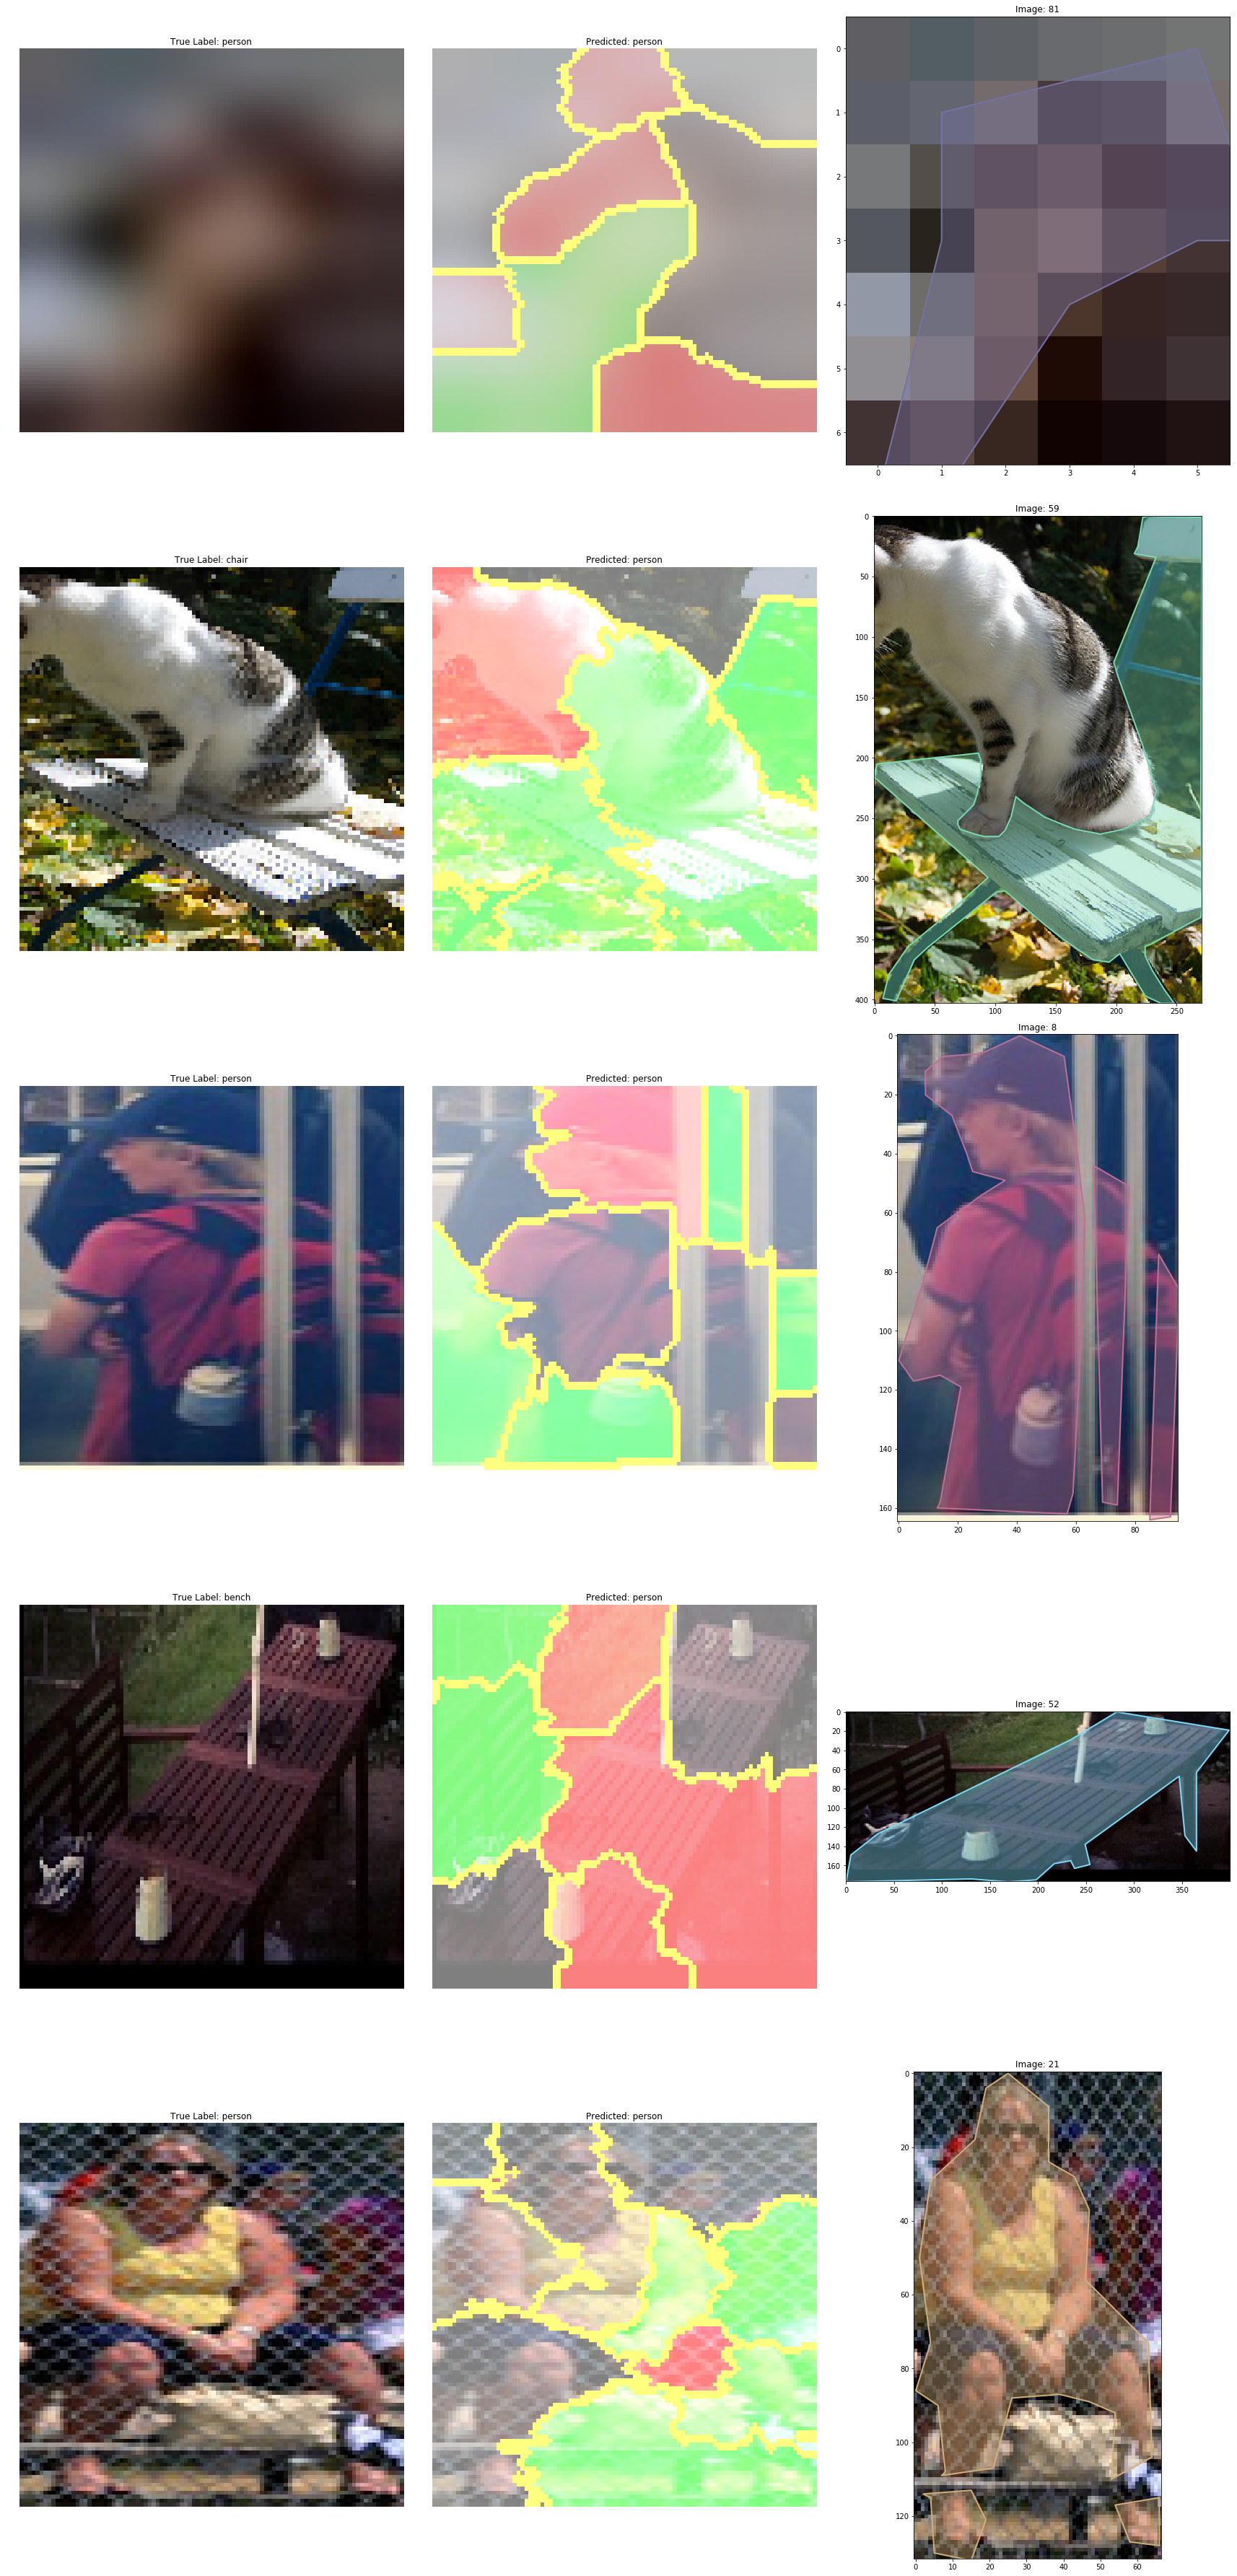

Ran for 6.701 seconds!! (0.112 minutes)
CPU times: user 27.7 s, sys: 2.15 s, total: 29.9 s
Wall time: 6.7 s


In [27]:
%%time
# Using Epsilon-Greedy
start_iter = 0
num_training_samples = 100
num_iterations = 1
samples_per_iter = num_training_samples // num_iterations
explainer_batch_size = 128
batch_size = 128
sp = SubPlotter(num_iterations, use_bandits=True)

for iteration in range(start_iter, start_iter + num_iterations):
    start = iteration * samples_per_iter
    end = (iteration + 1) * samples_per_iter
    
    x_train_batch = x_train[start:end]
    y_train_batch = y_train[start:end]
    configs_batch = configs[start:end]
    shapely_polygons_batch = shapely_polygons[start:end]
    
#     model.fit(x_train_batch, y_train_batch,
#               epochs=1,
#               batch_size=batch_size,
#               shuffle=False,
#               validation_data=(x_train[-100:], y_train[-100:]))
    
#     info = sp.analyzeIoU(model, x_train_batch, y_train_batch, shapely_polygons_batch, limit=20)
#     sp.plot_seg_extremes(info, configs_batch)
    sp.plot_rand_segs(model, used_ids, catId_to_catName, 
                      x_train_batch, y_train_batch, shapely_polygons_batch, configs_batch, num_segs=5)

    print("loss, accuracy = {}\n".format(model.evaluate(x_train, y_train, batch_size=128, verbose=0)))

sp.end()

### Load Single Image (either run this or the `Load All Images` section)

In [7]:
imgIds = [img_info for used_id in used_ids for img_info in coco.getImgIds(catIds=used_id)]
# img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])
img = coco.loadImgs(70229)[0]

In [8]:
print(img)

{'license': 1, 'file_name': '000000070229.jpg', 'coco_url': 'http://images.cocodataset.org/val2017/000000070229.jpg', 'height': 640, 'width': 481, 'date_captured': '2013-11-24 02:18:11', 'flickr_url': 'http://farm8.staticflickr.com/7174/6397141265_aa0f0d8a4e_z.jpg', 'id': 70229}


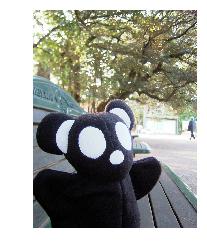

In [9]:
I = imread(img['coco_url'])
plt.axis('off')
plt.imshow(I)
plt.show()

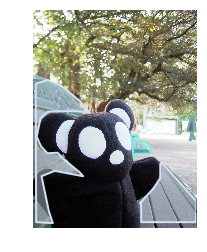

In [10]:
# load and display instance annotations
plt.imshow(I)
plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=used_ids, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

In [11]:
bboxImgs, object_labels, configs, shapelyPolygons = preprocess(coco, img, used_ids)

In [12]:
print(len(configs))

3


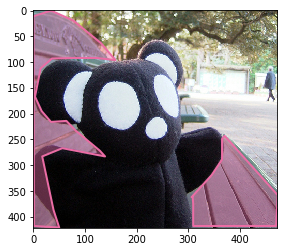

In [13]:
show_gt_mask(*configs[1])

p = Pgon(pairwise_group(alt_segs[0][0]))  
p.contains(Point(20, 60))